# Calibration Diagnostic

In [1]:
# These are the defaults for the run. They are overwritten on command-line.
observation = None
settings = ''
global_config = {}

In [2]:
# Parameters
observation = "."
settings = (
    "/home/smurray/data4/Projects/radio/EOR/Edges/edges-cal/tests/data/settings.yaml"
)
global_config = {}


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import edges_io as eio
import edges_cal as ec
from edges_cal.config import config
from pathlib import Path
import warnings
from beautifultable import BeautifulTable

This document shows the results of calibration for: 

In [4]:
config.update(global_config)
calobs = ec.CalibrationObservation.from_yaml(settings, obs_path=observation)
io_obs = calobs.metadata['io']

In [5]:
obspath = Path(io_obs.original_path).absolute()
print("Observation Location: ", obspath)

print("Date Run: ", datetime.now())
print("Version of edges-io:", eio.__version__)
print("Version of edges-cal:", ec.__version__)


Observation Location:  /data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2021_04_12_040_to_200MHz
Date Run:  2022-09-13 06:34:13.459912
Version of edges-io: 4.1.4.dev4+g24ca729.d20220909
Version of edges-cal: 6.2.3


In [6]:
antsims = {name: calobs.new_load(load_name=name, io_obj=io_obs) for name in io_obs.simulator_names}

/home/smurray/miniconda3/envs/edges/lib/python3.9/site-packages/hickle/lookup.py:1491: SerializedWarning: 'PosixPath' type not understood, data is serialized:
  warnings.warn(


/home/smurray/miniconda3/envs/edges/lib/python3.9/site-packages/hickle/lookup.py:1491: SerializedWarning: 'PosixPath' type not understood, data is serialized:
  warnings.warn(


## Observation Metadata

The following metadata fully defines this calibration for this version of `edges-cal`:

In [7]:
table = BeautifulTable()
table.rows.append(['wterms', calobs.wterms, 'cterms', calobs.cterms])
table.rows.append(['f_min', f"{calobs.freq.min:.2f} MHz", 'f_max', f"{calobs.freq.max:.2f} MHz"])
table.rows.append(['Ext. Calkit (rcv) Match Res.', f"{calobs.receiver.metadata['calkit'].match.resistance} Ohms", 'Int. Calkit Match Res.', f"{calobs.internal_switch.metadata['calkit'].match.resistance} Ohms"])
table.rows.append([ "Receiver S11 nterms", calobs.receiver.n_terms, '', ''])
print(table)
print()

table = BeautifulTable()
table.columns.header = [
    'S11 Run', 
    'Spec/Res. Run', 
    'S11 Rep.', 
    'Ignored %', 
    'S11 nterms',
]
sources = []
for name, source in calobs.loads.items():
    sources.append(name)
    table.rows.append([
        io_obs.s11.run_num[name],
        io_obs.spectra.run_num[name],
        io_obs.s11.repeat_num[name],
        source.spectrum.metadata['ignore_times_percent'],
        source.reflections.n_terms,
    ])
table.rows.header = sources
print(table)

print()
print("Antenna Simulators Available:", ', '.join(sorted(io_obs.simulator_names)))

+-----------------------+-----------------+-----------------+------------------+
|        wterms         |       12        |     cterms      |        10        |
+-----------------------+-----------------+-----------------+------------------+
|         f_min         |  50.00 MHz MHz  |      f_max      |  100.00 MHz MHz  |
+-----------------------+-----------------+-----------------+------------------+
| Ext. Calkit (rcv) Mat | 49.998 Ohm Ohms | Int. Calkit Mat | 50.1531 Ohm Ohms |
|        ch Res.        |                 |     ch Res.     |                  |
+-----------------------+-----------------+-----------------+------------------+
|  Receiver S11 nterms  |       37        |                 |                  |
+-----------------------+-----------------+-----------------+------------------+

+----------+---------+---------------+----------+-----------+------------+
|          | S11 Run | Spec/Res. Run | S11 Rep. | Ignored % | S11 nterms |
+----------+---------+---------------+-

## Spectrum Data

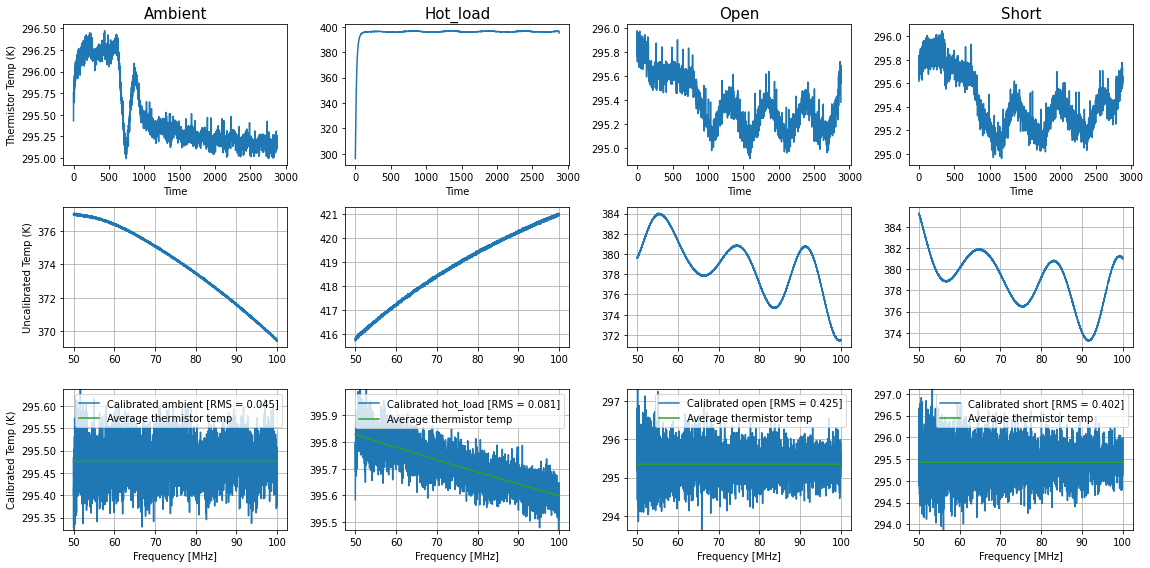

In [8]:
fig, ax = plt.subplots(
    3,4,figsize=(16,8), 
)

for i, (name, load) in enumerate(calobs.loads.items()):
    
    ec.plot.plot_resistance_measurements(io_obs.resistance._loads[name], ax=ax[0, i])
    ax[0,i].set_title(name.capitalize(), fontsize=15)
    ec.plot.plot_raw_spectrum(load.spectrum, fig=fig, ax=ax[1,i], ylabel=False, xlabel=False)
    calobs.plot_calibrated_temp(load, ax=ax[2,i],ylabel=False)
    
ax[0,0].set_ylabel("Thermistor Temp (K)")
ax[1,0].set_ylabel("Uncalibrated Temp (K)")
ax[2,0].set_ylabel("Calibrated Temp (K)")

plt.tight_layout()

**Figure 1 | Spectrum Measurements.** Each column is a known input calibrator source. Top row is the measured thermistor temperature in K as a function of time (in number of integrations). Second row is the *uncalibrated* measured temperature of the spectrum, as a function of frequency. The third row is the *calibrated* temperature (see figure 5 for the calibration coefficients) shown against the average thermistor temperature across the band.

/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/tools.py:402: RuntimeWarning: Mean of empty slice
  return np.nanmean(x[..., :nn].reshape(x.shape[:-1] + (-1, size)), axis=-1)


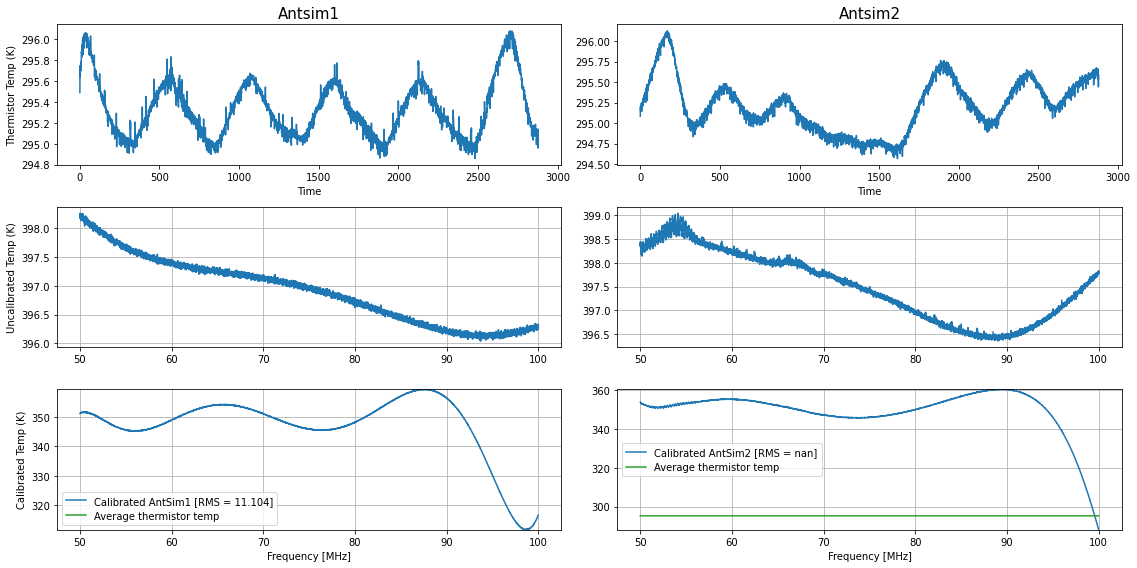

In [9]:
fig, ax = plt.subplots(
    3,len(antsims),figsize=(16,8), squeeze=False
)

for i, (name, load) in enumerate(antsims.items()):
    ec.plot.plot_resistance_measurements(io_obs.resistance.simulators[name], ax=ax[0, i])
    ax[0,i].set_title(name.capitalize(), fontsize=15)
    ec.plot.plot_raw_spectrum(load.spectrum, fig=fig, ax=ax[1,i], ylabel=False, xlabel=False)
    calobs.plot_calibrated_temp(load, ax=ax[2,i],ylabel=False)
    
ax[0,0].set_ylabel("Thermistor Temp (K)")
ax[1,0].set_ylabel("Uncalibrated Temp (K)")
ax[2,0].set_ylabel("Calibrated Temp (K)")

plt.tight_layout()

**Figure 2 | Antenna Simulator Spectra.** This plot shows the same measurements as Figure 1, but for the antenna simulators measured in this calibration.

## S11

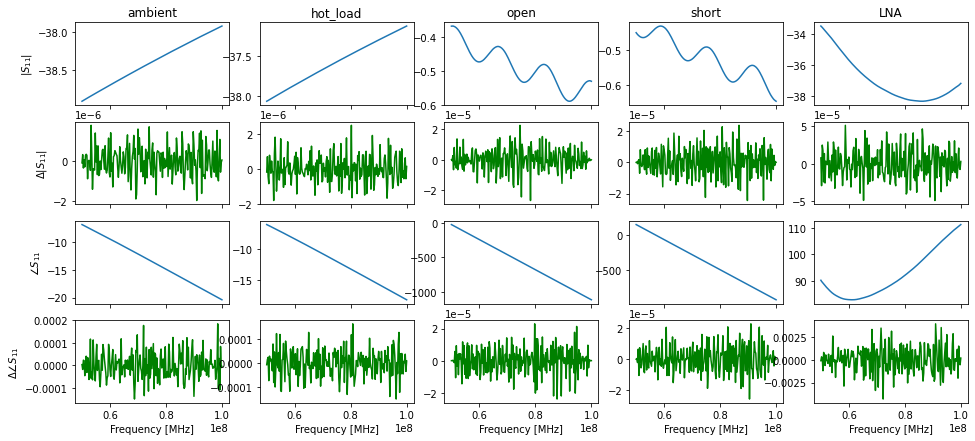

In [10]:
fig, ax = plt.subplots(4,5, sharex=True, figsize=(16, 7))
warnings.filterwarnings("ignore", category=DeprecationWarning)

for i, (name, source) in enumerate(calobs.loads.items()):
    source.reflections.plot_residuals(fig=fig, ax=ax[:,i], title=False, decade_ticks=False,ylabels=not i)
    ax[0,i].set_title(name)
    
calobs.receiver.plot_residuals(fig=fig, ax=ax[:,-1], title=False, decade_ticks=False,ylabels=False)
ax[0,-1].set_title("LNA");

**Figure 3 | Reflection Measurements.** This shows the reflection coefficient, $S_{11}$, for each input calibrator (columns). Top row shows the measured magnitude, second row the error in the model of the magnitude, the third row shows the phase angle and the bottom row shows the error in the magnitude of the phase. 

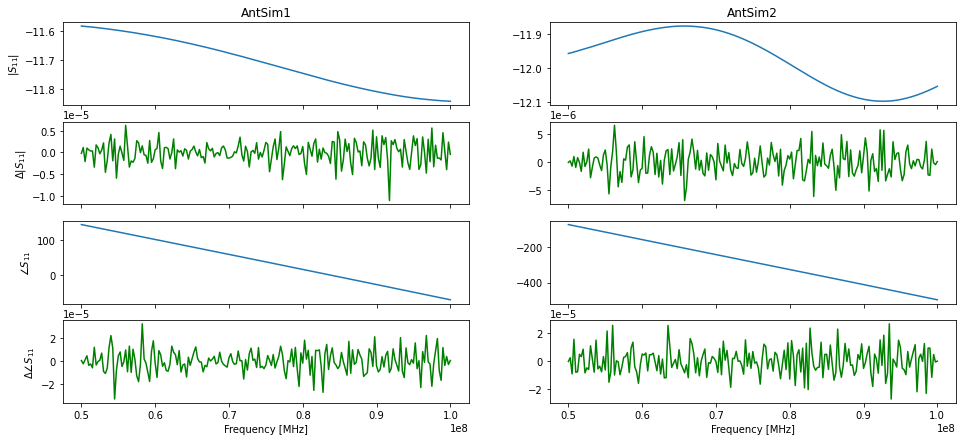

In [11]:
fig, ax = plt.subplots(4,len(antsims), sharex=True, figsize=(16, 7), squeeze=False)
warnings.filterwarnings("ignore", category=DeprecationWarning)

for i, (name, source) in enumerate(antsims.items()):
    source.reflections.plot_residuals(fig=fig, ax=ax[:,i], title=False, decade_ticks=False,ylabels=not i)
    ax[0,i].set_title(name)

**Figure 4 | Antenna Simulator Reflection Coefficients.** The same as Fig. 3, but for the antenna simulators measured for this calibration observation.

## Calibration

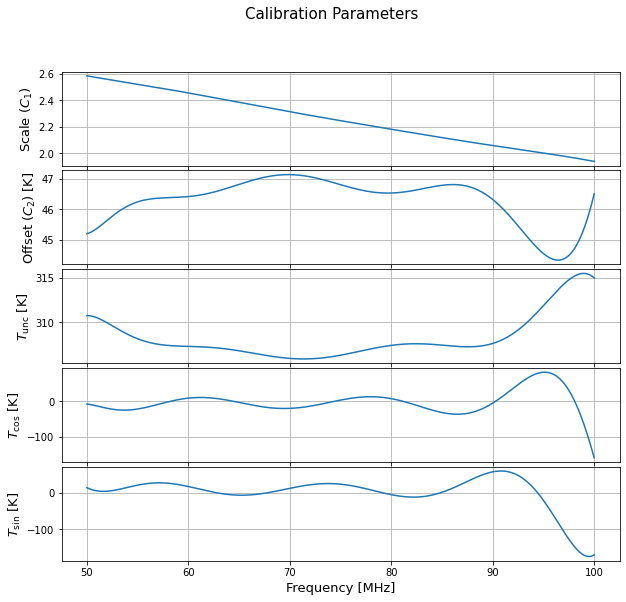

In [12]:
calobs.plot_coefficients();

**Figure 5 | Calibration Coefficients.** This shows the calibration coefficients as a function of frequency, as measured by optimizing the RMS of the calibrated temperatures of the input calibrator sources. The top row shows the overall scaling of the temperature required, the second row shows the overall offset, and the third, fourth and fifth rows show the noise-wave parameters (uncorrelated, cosine and sine).

## All Files Used

In [13]:
import os
def list_files(startpath, filter_list):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(str(startpath), '').count(os.sep)
        indent = ' ' * 4 * (level)
        ff = [f for f in files if any(str(x).startswith(str(Path(root)/f)) for x in filter_list)]
        dd = [d for d in dirs if any(str(x).startswith(str(Path(root)/d)) for x in filter_list)]
        if ff or dd:
            print('{}{}/'.format(indent, os.path.basename(root)))
        if ff:
            subindent = ' ' * 4 * (level + 1)
            for f in ff:
                print('{}{}'.format(subindent, f))

In [14]:
fl = io_obs.list_of_files[0]
list_files(obspath.parent, io_obs.list_of_files)

Receiver01/


    Receiver01_25C_2021_04_12_040_to_200MHz/
        S11/
            SwitchingState01/
                ExternalOpen02.s1p
                ExternalShort02.s1p
                Short02.s1p
                Open02.s1p
                ExternalMatch02.s1p
                Match02.s1p
            ReceiverReading01/
                ReceiverReading02.s1p
                Short02.s1p
                Open02.s1p
                Match02.s1p
            LongCableOpen01/
                External02.s1p
                Short02.s1p
                Open02.s1p
                Match02.s1p
            HotLoad01/
                External02.s1p
                Short02.s1p
                Open02.s1p
                Match02.s1p
            Ambient01/
                External02.s1p
                Short02.s1p
                Open02.s1p
                Match02.s1p
            LongCableShorted01/
                External02.s1p
                Short02.s1p
                Open02.s1p
                Match02.s1p
       